### Create a model to account for the spatial autocorrelation in the GWP model using distance-weighted means of surrounding spatial locations.

In [ ]:
## Install libs
!pip install -q geopandas
!pip install -q git+https://github.com/stevenpawley/Pyspatialml
!pip install -q dask==2021.12 scipy==1.7.0
!pip install -q auto-sklearn --upgrade

In [1]:
## Connect to google drive to read/save files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, glob
import pandas as pd
import geopandas as gpd
import numpy as np
from copy import deepcopy
from tempfile import NamedTemporaryFile
from pyspatialml import Raster
import pyspatialml.datasets.meuse as ms
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%config InlineBackend.figure_format ='retina'
%matplotlib inline

## Preparing the Raster Predictors

In [ ]:
## Working directory. Change to your working directory
wdir = '/content/drive/MyDrive/ACADEMIC/GWP/Factors/'
predictor_files = glob.glob(wdir + '*.tif')
print('Number of predictors:',len(predictor_files))
predictor_files

Number of predictors: 13


['/content/drive/MyDrive/ACADEMIC/GWP/Factors/Soil_type.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/Land_use.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/Curvature_class.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/Altitude.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/DtW.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/Slope.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/DF.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/STI.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/TWI.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/Aspect_9class.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/pred_regression.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/Geology.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/Precipitation_class.tif']

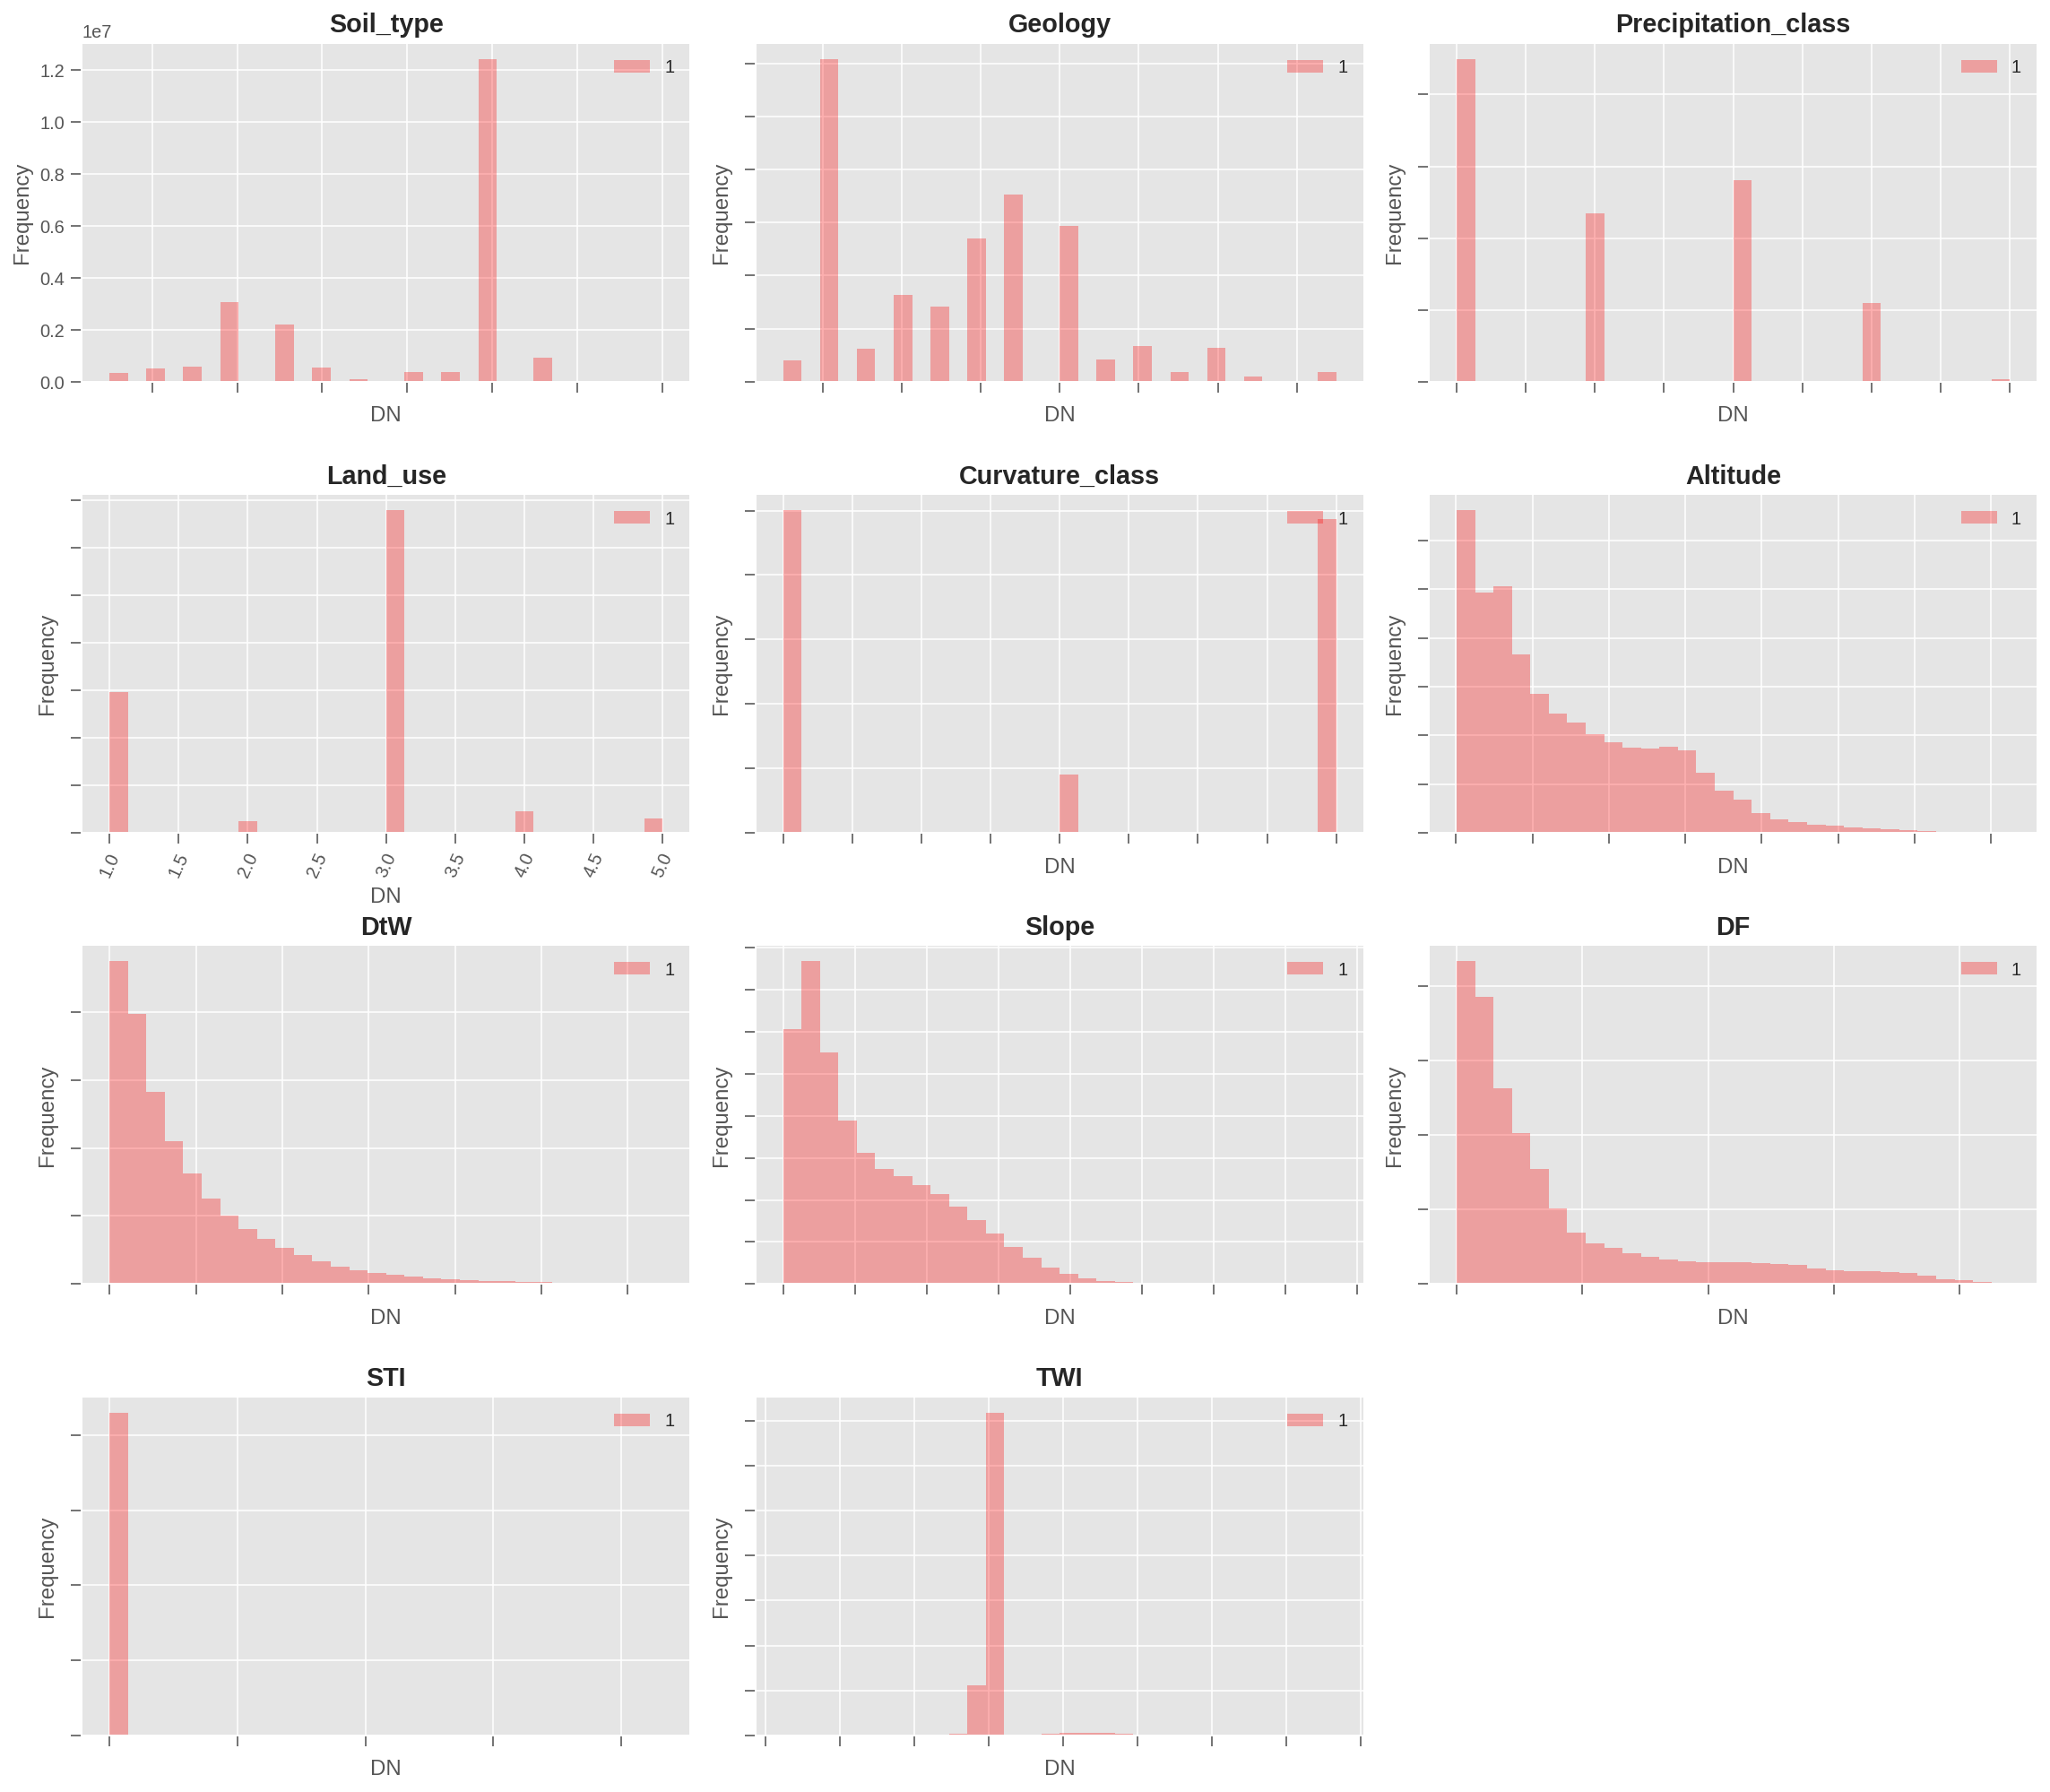

In [ ]:
## Explore the predictor distribution.
import rasterio
from rasterio.plot import show_hist
mpl.style.use('ggplot')

fig, axs = plt.subplots(4, 3, figsize=(16, 14))

for i, (ax, target,src) in enumerate(zip(axs.ravel(), list(stack.names), predictor_files)):
    src = rasterio.open(src)
    show_hist(
        src, bins=30, lw=0.0, stacked=False, alpha=0.3,
        histtype='stepfilled', title=target,ax=ax)
    
    if i != 0:
        ax.set_yticklabels([])
    
    if i != 3:
        ax.set_xticklabels([])
    else:
        ax.tick_params(axis='x', labelrotation=65)
    
fig.delaxes(axs.flatten()[i])
plt.tight_layout()

**!!! The histogram plots show that some features such as STI, TWI can be dropped from the input feature set. However, I'll just leave them there for now.**

In [ ]:
## Stack predictors into a raster stack for model training
stack = Raster(predictor_files)
stack.names

dict_keys(['Soil_type', 'Land_use', 'Curvature_class', 'Altitude', 'DtW', 'Slope', 'DF', 'STI', 'TWI', 'Aspect_9class', 'pred_regression', 'Geology', 'Precipitation_class'])

In [ ]:
drop_features = ['Curvature_class','STI', 'TWI','pred_regression', 'Aspect_9class']
stack.drop(drop_features, in_place=True)
stack.names

dict_keys(['Soil_type', 'Land_use', 'Altitude', 'DtW', 'Slope', 'DF', 'Geology', 'Precipitation_class'])

In [ ]:
## Maps the predictors for exploration
red_green=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
for lyr in stack.names:
    # stack[lyr].cmap = 'viridis'#'coolwarm'
    stack[lyr].cmap = 'coolwarm'
    # stack[lyr].cmap = red_green #'coolwarm'

In [ ]:
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(16, 14))
# ax = axs.flatten()[10]
# im = ax.images
# im[0].colorbar.set_ticks([1,2,3])
# ax = axs.flatten()[8]
# ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**!!! Curvature class and aspect features are pretty noisy**

### Explore the training dataset

In [ ]:
training_pts_file = wdir + '499_data.csv'
training_df = pd.read_csv(training_pts_file, usecols=['x','y','Yield'])
training_df.head()
training_pts = gpd.GeoDataFrame(training_df, geometry=gpd.points_from_xy(training_df.x, training_df.y))
training_pts.head()

,x,y,Yield,geometry
0,556396,1549876,20.0,POINT (556396.000 1549876.000)
1,569301,1636075,12.0,POINT (569301.000 1636075.000)
2,464618,1620454,3.0,POINT (464618.000 1620454.000)
3,552604,1606985,12.0,POINT (552604.000 1606985.000)
4,551454,1586116,8.0,POINT (551454.000 1586116.000)


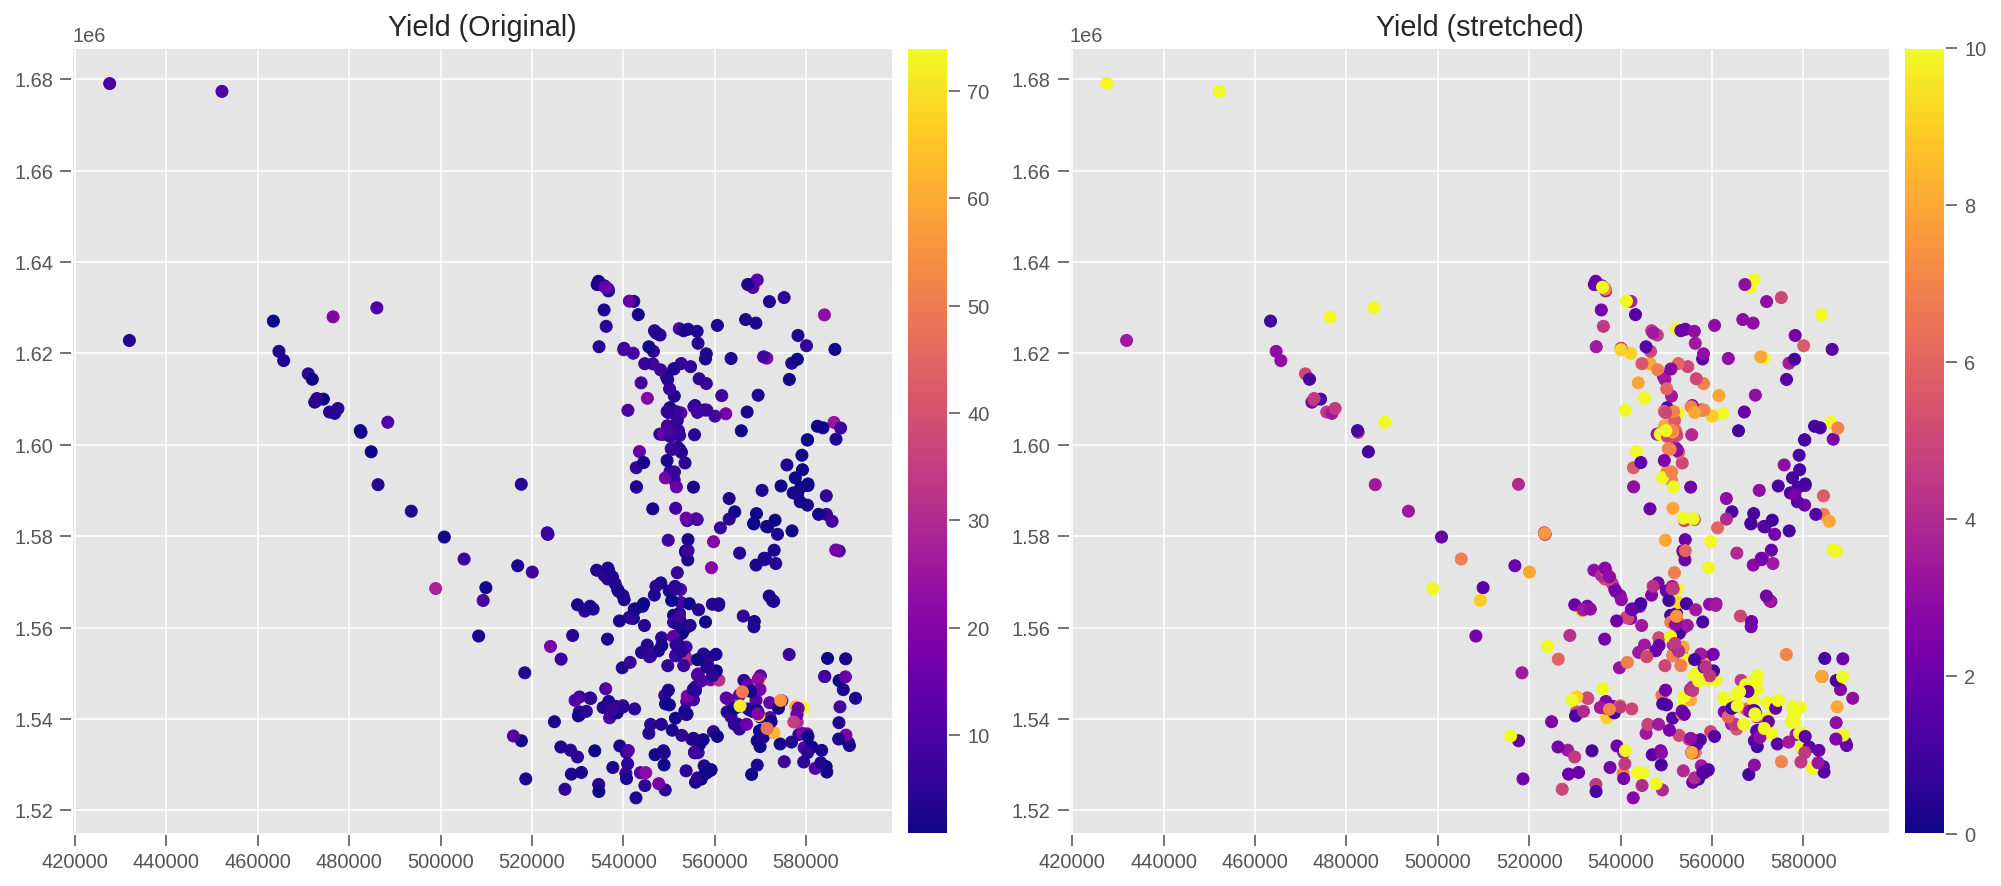

In [ ]:
## Explore the data range of the training data.
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.style.use('ggplot')

fig, axes = plt.subplots(1,2, figsize=(14, 7))
target = 'Yield'
axes[0].set_title(target.title() + ' (Original)')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
im1 = training_pts.plot(column=target, legend=True, ax=axes[0],cmap='plasma', cax=cax)

axes[1].set_title(target.title() + ' (stretched)')
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
im2 = training_pts.plot(column=target, legend=True, ax=axes[1], cmap='plasma',vmin=0, vmax=10, cax=cax)

# cbar = fig.colorbar(im2, ticks=[0, 2, 10])
plt.tight_layout()
plt.show()

In [ ]:
# training_pts.hist(figsize=(15,30),layout=(9,3))

Text(0.5, 1.0, 'Yield histogram')

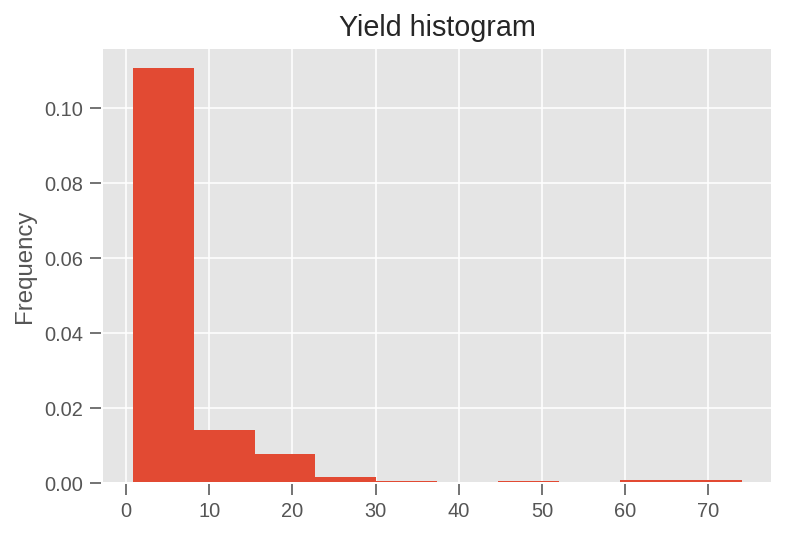

In [ ]:
training_df[target].plot.hist(target,density=True)
# plt.hist(training_df[target], bins=[0, 2, 10, max(training_df[target])])
plt.title('Yield histogram')

**!!! The dataset doesn't have good spatial variation for model training, or there are some outliers that migh skew the distribution.**

### Generate new features from surrounding spatial locations, using x,y coordinates. These features will be used to calculate spatial lags for model training

In [ ]:
from pyspatialml.preprocessing import xy_coordinates

xy_layers = xy_coordinates(stack.iloc[0], NamedTemporaryFile(suffix=".tif").name)
xy_layers.rename({
    old: new for (old, new) in zip(xy_layers.names, ["x_coord", "y_coord"])},
    in_place=True
)
stack = stack.append(xy_layers, in_place=False)

Quickly plot the raster predictors with coordinates

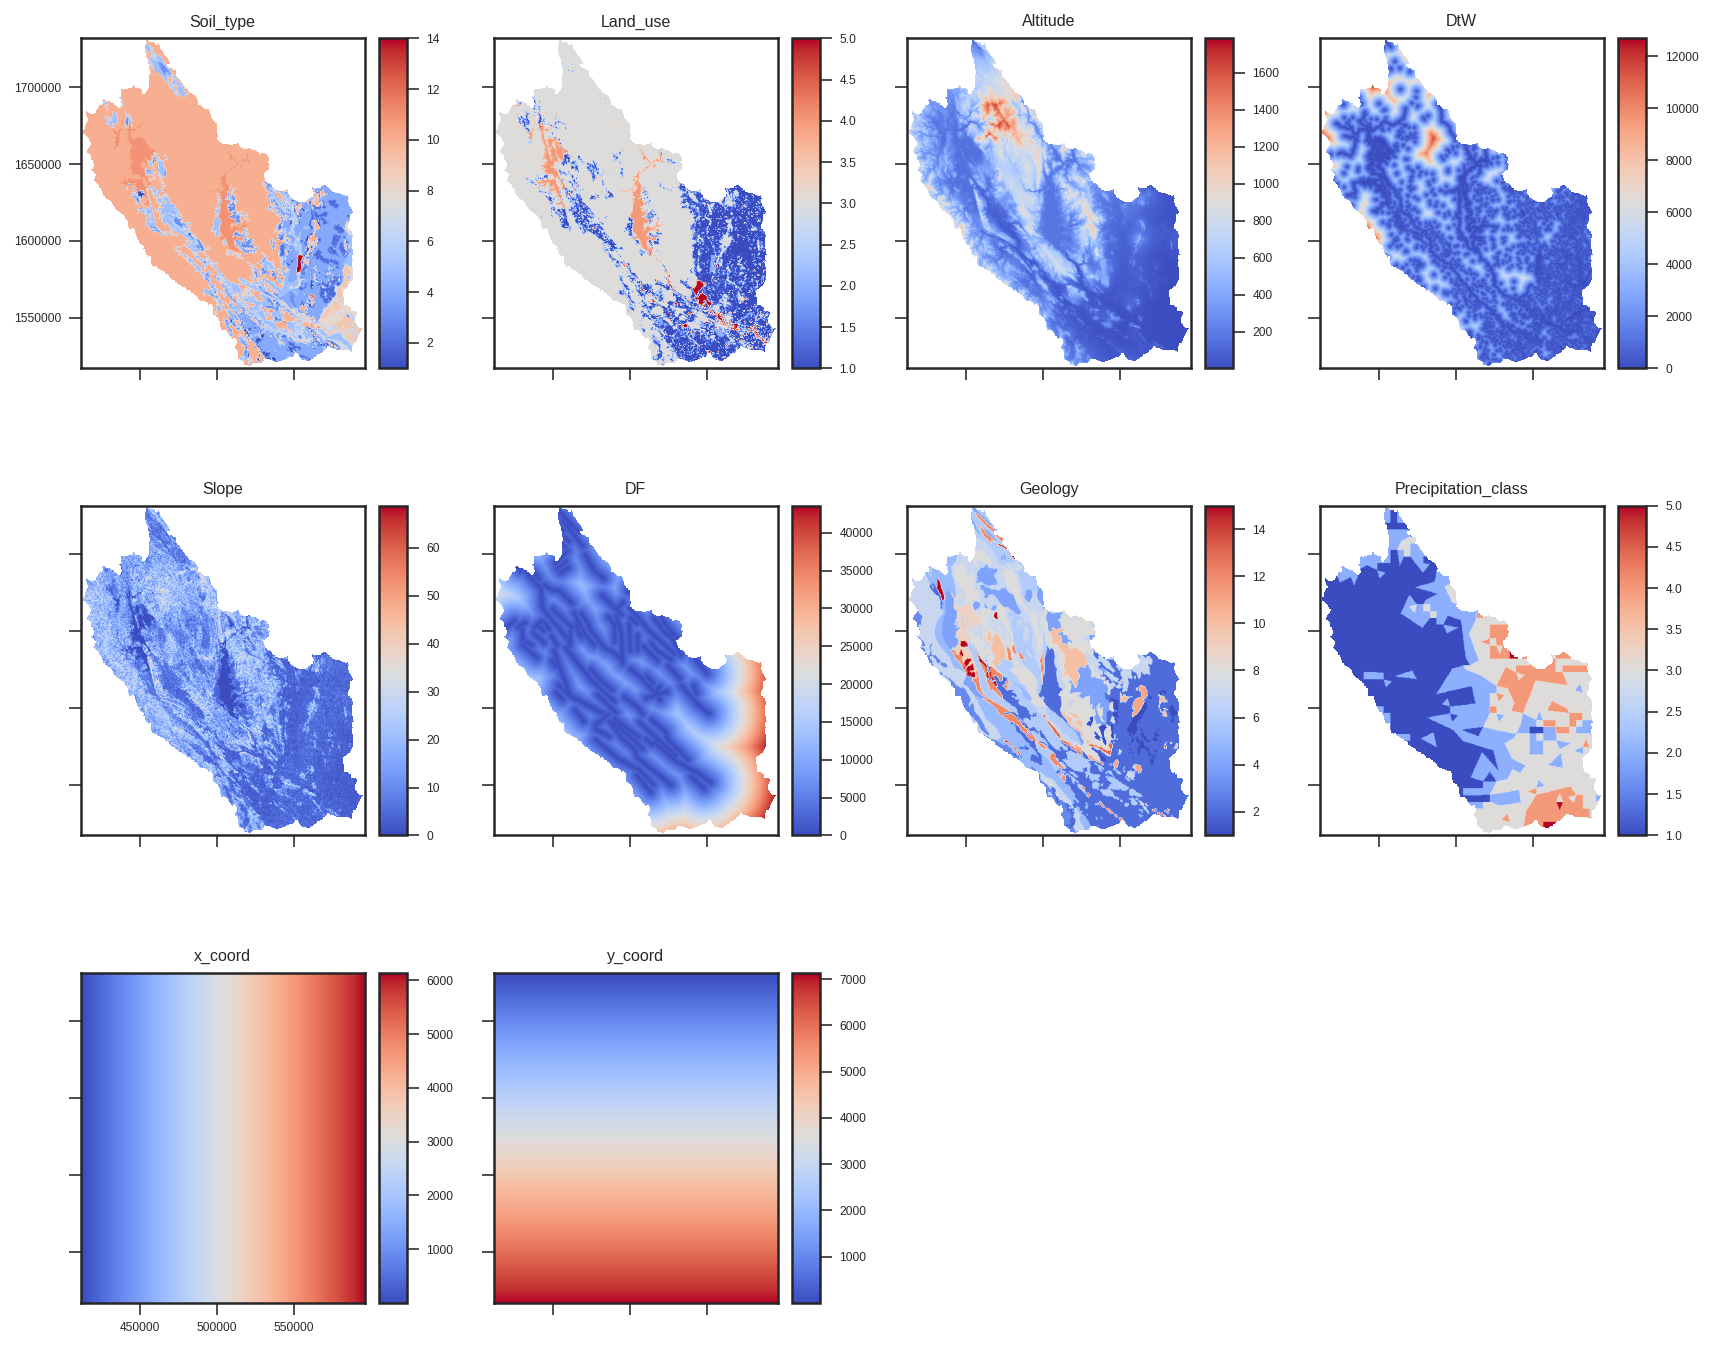

In [ ]:
for lyr in stack.names:
    stack[lyr].cmap = 'coolwarm'
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(12, 10))
# ax = axs.flatten()[10]
# im = ax.images
# im[0].colorbar.set_ticks([1,2,3])
# ax = axs.flatten()[8]
# ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

## Extract the Training Data

Spatially query the raster predictors at the training point locations:

In [ ]:
training_df = stack.extract_vector(gdf=training_pts)

training_df.index = training_df.index.get_level_values("geometry_idx")
training_df = training_df.merge(
    training_pts.loc[:, ("Yield")], 
    left_index=True, 
    right_index=True
) 
training_df = training_df.dropna()
training_df.head()

,Soil_type,Land_use,Altitude,DtW,Slope,DF,Geology,Precipitation_class,x_coord,y_coord,geometry,Yield
geometry_idx,,,,,,,,,,,,
0,6.0,5.0,21.0,60.000000,4.691967,4686.533691,2.0,2.0,4835.0,6059.0,POINT (556396.000 1549876.000),20.0
1,4.0,1.0,79.0,182.482880,6.696347,23825.232422,2.0,4.0,5265.0,3186.0,POINT (569301.000 1636075.000),12.0
2,5.0,5.0,66.0,421.070068,12.303771,6236.104492,2.0,2.0,1776.0,3706.0,POINT (464618.000 1620454.000),3.0
3,4.0,1.0,114.0,1081.665405,4.168740,9378.155273,10.0,3.0,4709.0,4155.0,POINT (552604.000 1606985.000),12.0
4,4.0,1.0,75.0,247.386337,3.181813,10145.368164,2.0,1.0,4670.0,4851.0,POINT (551454.000 1586116.000),8.0


Split the response/target variables from the predictors:

In [ ]:
X = training_df.loc[:, stack.names].values
y = training_df.loc[:, ['Yield']].values.ravel() # use ravel() to 1d array to flatten it
y

array([20.  , 12.  ,  3.  , 12.  ,  8.  ,  4.  , 18.  ,  7.  ,  6.  ,
        8.  , 20.  ,  8.  ,  5.  ,  8.  , 18.  ,  8.  , 16.  , 20.  ,
       20.  ,  5.  , 10.  , 16.  ,  7.  , 12.  , 25.  , 10.  , 10.  ,
        9.  , 10.  ,  3.41,  3.41,  2.5 ,  9.09,  3.41,  5.  ,  4.5 ,
        2.27,  7.  ,  2.95,  3.41,  3.41,  4.1 ,  1.59,  8.  ,  8.  ,
        5.4 ,  6.  ,  4.  ,  4.54, 10.2 ,  3.5 ,  1.36,  1.59,  2.7 ,
        8.  ,  3.41,  3.41,  6.81,  3.41,  6.  ,  6.8 ,  5.7 , 15.  ,
        8.  ,  9.  ,  2.27,  3.41,  6.  ,  2.4 ,  3.4 ,  2.8 , 10.  ,
        5.  , 10.  ,  4.  ,  3.41,  2.  ,  3.4 ,  6.8 ,  3.41,  5.  ,
        9.08,  3.41,  2.27,  1.82,  4.5 ,  2.5 ,  2.27,  1.82,  3.41,
        3.41,  3.41,  3.18,  6.5 ,  3.  ,  2.  ,  3.  ,  3.  ,  3.  ,
        3.  ,  5.68,  3.5 ,  4.  ,  5.  ,  4.5 ,  4.5 ,  8.  ,  3.41,
        3.41,  3.41,  2.72,  8.  , 10.  ,  5.  ,  5.  ,  3.  ,  5.  ,
        2.27,  2.  ,  3.  ,  2.27,  3.41,  2.  ,  3.  ,  4.  ,  3.  ,
        8.12,  4.8 ,

## Develop a Spatially-Lagged Machine Learning Model to predict Water Yield

Use ExtraTreeRegressor model with `pyspatialml.estimators.SpatialLagRegressor` metalearner class to wrap the extratrees regressor into a model that adds a new feature based on the distance-weighted mean of spatially-proximal observations:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from pyspatialml.transformers import KNNTransformer
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import GridSearchCV, cross_val_predict

# define regressor
et = ExtraTreesRegressor(n_estimators=100, n_jobs=-1, random_state=1234)

## Transform categorical and create the lag feature using KNN
#['Soil_type', 'Geology', 'Precipitation_class', 'Land_use', 'Curvature_class', 'Altitude', 'DtW', 'Slope', 'DF', 'STI', 'TWI', 'Aspect_9class']
# cat_index1 = list(stack.names).index("Soil_type")
# cat_index2 = list(stack.names).index("Geology")
# cat_index3 = list(stack.names).index("Curvature_class")
# cat_index4 = list(stack.names).index("Aspect_9class")
# cat_index5 = list(stack.names).index("Precipitation_class")
xy_indexes = [list(stack.names).index(i) for i in ["x_coord", "y_coord"]]

cat_variables = ['Soil_type', 'Geology' ,'Curvature_class', 'Aspect_9class', 'Precipitation_class']
cat_indexes = []
stack_names = list(stack.names)
for x in cat_variables:
    try:
        cat_index = stack_names.index(x)
        cat_indexes.append(cat_index)
    except:
        pass
print(cat_indexes)

preproc = ColumnTransformer([
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), cat_indexes),
    ('lags', KNNTransformer(weights='distance', measure="mean"), xy_indexes)
], remainder='passthrough')

wflow = Pipeline([
    ('preproc', preproc),
    ('regressor', et)
])

## Search for best hyperparameters
search_grid = {"preproc__lags__n_neighbors": [3, 5, 7, 9]}
inner = KFold(n_splits=3, shuffle=True, random_state=1234)
model1 = GridSearchCV(wflow, param_grid=search_grid, cv=inner, scoring="neg_mean_squared_error")

[0, 6, 7]


Fit the model and cross-validate:

In [ ]:
# Fit
model1 = model1.fit(X, y)
model1.best_params_

{'preproc__lags__n_neighbors': 3}

In [ ]:
model1

GridSearchCV(cv=KFold(n_splits=3, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [0, 6,
                                                                          7]),
                                                                        ('lags',
                                                                         KNNTransformer(),
                                                                         [8,
                                                                          9])])),
                                       ('regressor',
                                        ExtraTreesRegressor(n_

In [ ]:
model1.cv_results_ 

{'mean_fit_time': array([1.35025096, 0.29723088, 0.29325151, 0.30447133]),
 'mean_score_time': array([0.11597522, 0.10588868, 0.10599923, 0.10653472]),
 'mean_test_score': array([-78.30216645, -79.62589449, -81.70852968, -81.41867   ]),
 'param_preproc__lags__n_neighbors': masked_array(data=[3, 5, 7, 9],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'preproc__lags__n_neighbors': 3},
  {'preproc__lags__n_neighbors': 5},
  {'preproc__lags__n_neighbors': 7},
  {'preproc__lags__n_neighbors': 9}],
 'rank_test_score': array([1, 2, 4, 3], dtype=int32),
 'split0_test_score': array([ -97.18149235, -108.48039664, -109.71704221, -103.32307326]),
 'split1_test_score': array([-81.28071439, -77.18821421, -77.94987833, -80.13741328]),
 'split2_test_score': array([-56.44429262, -53.20907264, -57.45866851, -60.79552345]),
 'std_fit_time': array([1.16824728, 0.00466996, 0.01121934, 0.01545752]),
 'std_score_time': array([1.30449316e-02,

In [ ]:
rmse = np.sqrt(-model1.cv_results_['mean_test_score']).mean()
print("RMSE score is {}".format(rmse))

RMSE score is 8.958672982226007


In [ ]:
## Save the model for use later
import pickle
# save the model to disk
filename = wdir + 'model_regression_8.sav'
pickle.dump(model1, open(filename, 'wb'))

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
# CV
outer = KFold(n_splits=10, shuffle=True, random_state=1234)
scores = cross_validate(model1, X, y, scoring=['neg_mean_squared_error','r2','explained_variance','neg_mean_absolute_percentage_error'], cv=outer, n_jobs=4)
scores

{'fit_time': array([10.02026176, 10.29308796, 10.30266929, 10.26476455, 10.53529644,
        10.63310361, 11.78416491, 11.87000322, 10.34654069, 10.35999823]),
 'score_time': array([0.13461375, 0.11223912, 0.12633586, 0.13840008, 0.14279938,
        0.13316417, 0.13911724, 0.14409637, 0.1457119 , 0.10899472]),
 'test_explained_variance': array([ 0.05083993, -0.54692323,  0.04626091,  0.4592313 ,  0.16226067,
        -3.67660695, -1.44669277, -0.81022753, -0.0604391 ,  0.33225208]),
 'test_neg_mean_absolute_percentage_error': array([-1.1354415 , -1.10064185, -1.55999391, -1.28973843, -1.1930084 ,
        -2.03576622, -1.41589554, -1.02571629, -1.03844025, -1.30021261]),
 'test_neg_mean_squared_error': array([-105.90859937, -148.48992995, -207.70382794,  -35.54620934,
         -81.95865186,  -71.40597494,  -78.46529201,  -48.48688208,
         -59.64483616,  -91.45095121]),
 'test_r2': array([ 0.04110323, -0.55896089,  0.04617373,  0.41048507,  0.15857177,
        -4.30445743, -1.6359507

In [ ]:
## RMSE metric
rmse = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
print("Mean RMSE score is {}".format(rmse))

Mean RMSE score is 9.346146184686507


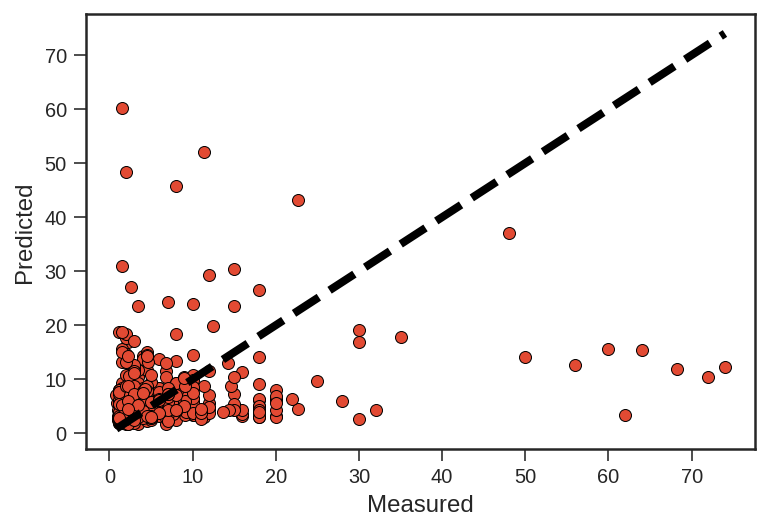

In [ ]:
# Plot residual
from sklearn.metrics import r2_score

predicted = cross_val_predict(model1, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()


**!!! The results show the model is not doing a good job at predicting yield yet. Model retrain is recommended**

### Predictions

In [ ]:
pred_map = wdir + 'pred_regression.tif'
preds = stack.predict(model1, progress=True,file_path=pred_map) # Took about 14mins for the prediction

100%|█████████▉| 699/700 [05:41<00:00,  2.05it/s]


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:488: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


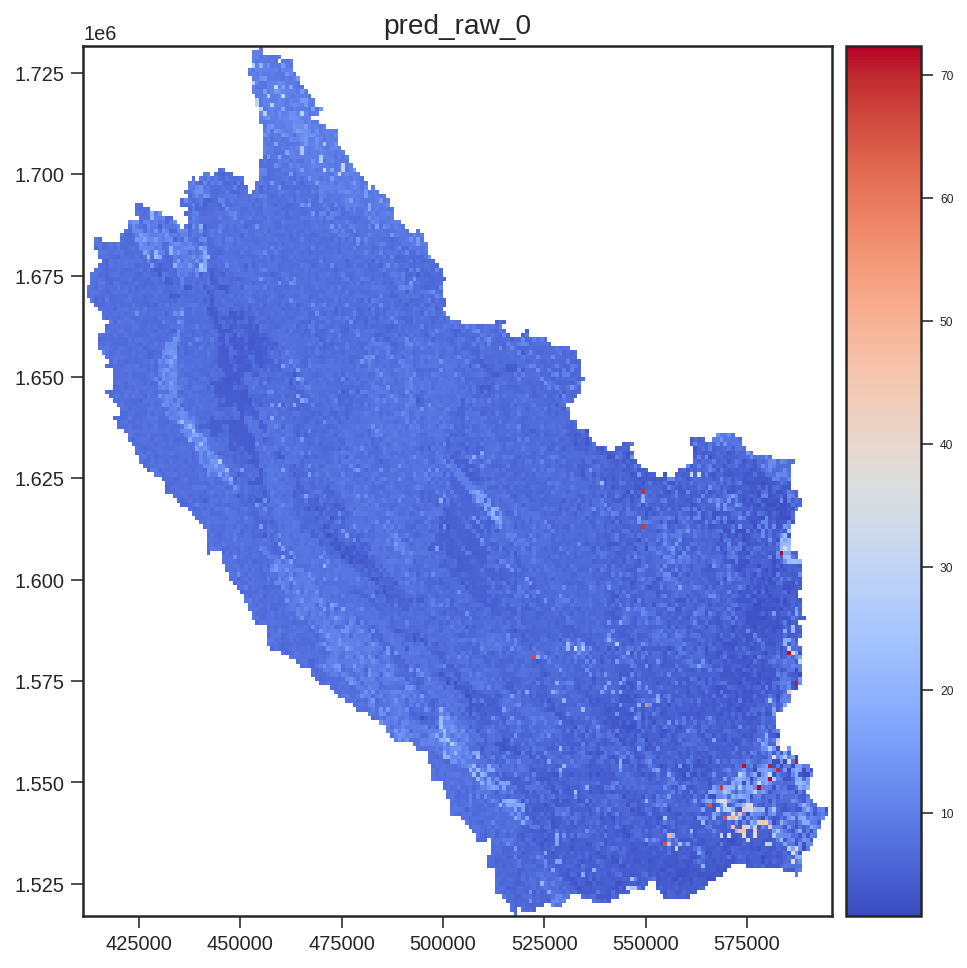

In [ ]:
## Plot prediction maps
mpl.style.use('seaborn-ticks')
f = preds.plot(out_shape=(200, 200), title_fontsize=14,figsize=(10, 8), vmin=-10, vmax=40,)
f.get_figure().savefig(wdir + 'pred_map.png')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## CLASSIFICATION

In [ ]:
import numpy as np
from scipy import interp

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_fscore_support
from autosklearn.classification import AutoSklearnClassifier
from sklearn.preprocessing import LabelBinarizer


In [ ]:
## Turn yield into 2 classes of 0 and 1 based on threshold of 10 cm3/s
y_cat = np.where(y > 10, 1, 0)
pd.DataFrame(y_cat).value_counts()

0    426
1     73
dtype: int64

In [ ]:
# split into train and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_cat, test_size=0.3, random_state=1)
print('Class Count in training:')
print(pd.DataFrame(y_train2).value_counts())
print('Class Count in testing:')
print(pd.DataFrame(y_test2).value_counts())

Class Count in training:
0    294
1     55
dtype: int64
Class Count in testing:
0    132
1     18
dtype: int64


In [ ]:
# Define search setup for best model using AutoSklearn
model2 = AutoSklearnClassifier(time_left_for_this_task=2*60, per_run_time_limit=30, n_jobs=8)
# perform the search
model2.fit(X_train2, y_train2)

# summarize
print(model2.sprint_statistics())

# evaluate best model
y_hat = model2.predict(X_test2)
acc = accuracy_score(y_test2, y_hat)
print("Accuracy: %.3f" % acc)

auto-sklearn results:
  Dataset name: 3370daba-760b-11ec-8324-0242ac1c0002
  Metric: accuracy
  Best validation score: 0.870690
  Number of target algorithm runs: 31
  Number of successful target algorithm runs: 30
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 0

Accuracy: 0.873


In [ ]:
## Calculate classifier model stats
def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

In [ ]:
## Report classifcation metrics
report_with_auc = class_report(
    y_true=y_test2, 
    y_pred=model2.predict(X_test2), 
    y_score=model2.predict_proba(X_test2))

print(report_with_auc)

             precision    recall  f1-score  support   pred       AUC
0             0.884354  0.984848  0.931900    132.0  147.0  0.558502
1             0.333333  0.055556  0.095238     18.0    3.0  0.558502
avg / total   0.818231  0.873333  0.831500    150.0  150.0  0.558502


**!!! Didn't do quite well for class 1 (high)**

In [ ]:
## Save the model for use later
import pickle
# save the model to disk
filename = wdir + 'model_2classes.sav'
pickle.dump(model2, open(filename, 'wb'))

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
pred_map = wdir + 'preds_2classes.tiff'
preds_2classes = stack.predict(model2, progress=True,file_path=pred_map)

In [ ]:
## Create probablity map
prob_map = wdir + 'prob_2classes.tiff'
preds_prob = stack.predict_proba(model2, progress=True,file_path=prob_map)

In [ ]:
## Plot prediction maps
mpl.style.use('seaborn-ticks')
f = preds.plot(out_shape=(200, 200), title_fontsize=14,figsize=(10, 8),vmin=-10, vmax=40,)
f.get_figure().savefig(wdir + 'pred_map2.png')
plt.show()

In [ ]:
## Plot prediction probablity maps
mpl.style.use('seaborn-ticks')
f = preds_prob.plot(out_shape=(200, 200), title_fontsize=14,figsize=(10, 8))
f.get_figure().savefig(wdir + 'pred_prob_map2.png')
plt.show()